## MICROSOFT RECOMMENDER, SAR ALGORITHM  

# Load Packages

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import scrapbook as sb
import matplotlib.pyplot as plt
import scipy, logging, sys, warnings, joblib
from sklearn.preprocessing import minmax_scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import recommenders
from recommenders.models.sar import SAR 
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.python_utils import binarize
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import (precision_at_k, mae, rsquared)

%load_ext autoreload
%autoreload 2
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
warnings.filterwarnings('ignore')
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.4.4


# Define a list of top_k items that will be recommended to users

In [2]:
list_top_k=[3,5,10]

# Load the data
	Jester dataset
  https://goldberg.berkeley.edu/jester-data/
  
  With the following preprocessing 

In [3]:
# we limit the size to 1M to save the time/momory as this notebook is an example 
df=pd.read_excel('jester-data-1.xls', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.03,-9.08,-7.14,-6.26,3.79,-0.10,3.93,...,-8.69,-7.14,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.64,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,...,3.16,9.03,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,9.27,99.00,9.27,99.00,6.17,7.33,9.08,...,99.00,99.00,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,99.00,6.84,6.84,-3.98,6.99,...,99.00,6.94,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,0.19,-8.74,5.24,6.31,8.06,1.26,4.51,...,4.42,3.06,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [4]:
data = df.copy()
# Creating a column for user IDs
uid = np.arange(1, len(data.index)+1)
data.insert(loc=1, column="userID", value=uid) 

# dropping the first column (represents the amount of jokes rated by each user)
data = data.drop([0], axis=1)
data.head()

,userID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,1,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,-8.11,-9.13,-9.03,-9.08,-7.14,-6.26,3.79,-0.10,3.93,...,-8.69,-7.14,3.20,8.30,-4.56,0.92,-9.13,-9.42,2.82,-8.64,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,2,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,7.82,-3.83,8.64,8.98,-4.32,-3.20,-4.90,-0.92,-1.46,...,3.16,9.03,0.97,-1.31,-6.50,-3.20,8.64,-2.14,0.10,9.03,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,3,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,7.52,9.27,9.27,99.00,9.27,99.00,6.17,7.33,9.08,...,99.00,99.00,7.28,7.33,99.00,7.23,99.00,99.00,99.00,9.27,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,4,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,99.00,1.55,99.00,99.00,99.00,6.84,6.84,-3.98,6.99,...,99.00,6.94,1.55,7.67,99.00,6.55,99.00,99.00,99.00,99.00,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,5,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,0.34,6.84,0.19,-8.74,5.24,6.31,8.06,1.26,4.51,...,4.42,3.06,8.93,7.82,1.75,8.11,-8.06,-9.17,4.95,3.35,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [5]:
# reformatting the dataframe
data = data.melt(id_vars="userID", var_name="itemID", value_name='rating')
# result
data.head()

,userID,itemID,rating
0,1,1,-7.82
1,2,1,4.08
2,3,1,99.00
3,4,1,99.00
4,5,1,8.50


In [6]:
data['rating']=data['rating'].replace(99, np.nan)
data.head()

,userID,itemID,rating
0,1,1,-7.82
1,2,1,4.08
2,3,1,NaN
3,4,1,NaN
4,5,1,8.50


In [7]:
data['rating'] = data['rating'].astype(np.float32)
data['userID'] = data['userID'].astype(np.int64)
data['itemID'] = data['itemID'].astype(np.int64)

In [8]:
data.shape

(2498300, 3)

In [9]:
# Messing values
data.isna().sum()

userID         0
itemID         0
rating    687845
dtype: int64

In [10]:
data.dropna(inplace=True)

In [11]:
# checking Messing values
data.isna().sum()

userID    0
itemID    0
rating    0
dtype: int64

In [12]:
data.shape

(1810455, 3)

# Split the data into train and test sets
	75% train set and 25% test set

In [13]:
train, test = python_stratified_split(data, 
                                      ratio=0.75,
                                      col_user='userID',
                                      col_item='itemID',
                                      seed=12345)
#(train.shape, test.shape)

In [14]:
print(
f"""Train: 
Total Ratings: {len(train)}
Unique Users:  {len(train['userID'].unique())}
Unique Items:  {len(train['itemID'].unique())}
"""
     )

print(
f"""Test: 
Total Ratings: {len(test)}
Unique Users:  {len(test['userID'].unique())}
Unique Items:  {len(test['itemID'].unique())}
"""
     )

Train: 
Total Ratings: 1357986
Unique Users:  24983
Unique Items:  98

Test: 
Total Ratings: 452469
Unique Users:  24983
Unique Items:  99



# Define the list of the similarities that will be investigated
Similarity type must be one of available similarity metrics:
	
	"cooccurrence", "jaccard", "lift", "HD_JACCARD", "DICE", "JACCARD_3W", "SOKAL_SNEATH_I", "COSINE", "SORGENFREI", "MOUNTFORD", "MCCONNAUGHEY", "KULCZYNSKI_II", "DRIVER_KROEBER", "JOHNSON", "SIMPSON", "BRAUN_BANQUET", "FAGER_MCGOWAN", "EUCLID", "MINKOWSKI", "LANCE_WILLIAMS", "HELLINGER", "CHORD",
 
	"SOKAL_MICHENER", "SOKAL_SNEATH_II", "SOKAL_SNEATH_IV", "SOKAL_SNEATH_V",  "PEARSON_I", "PEARSON_II", "PEARSON_III", "PEARSON_HERON_I", "PEARSON_HERON_II", "BARONI_URBANI_BUSER_I", "BARONI_URBANI_BUSER_II", "FORBES_I", "FORBES_II", "YULEQ", "YULEQ_W", "TARANTULA", "AMPLE", "ROGERS_TANIMOTO", "FAITH", "GOWER_LEGENDRE", "INNERPRODUCT", "RUSSELL_RAO", "TARWID", "DENNIS", "GOWER", "STILES", "FOSSUM", "DISPERSON", "HAMANN", "MICHAEL", "PEIRCE", "EYRAUD", "YULEQ_D", "MEAN_MANHATTAN", "VARI", "SHAPEDIFFERENCE", "PATTERNDIFFERENCE

In [42]:
# The list of the similarity metrics that already implemented in SAR algorithm
list_already_exist=[
    "jaccard" , 
    "lift"
    ]
print(len(list_already_exist),'similarity metrics already implemented')

#Define the list of the similarity metrics without negative co-occurrences
list_metrics=[
    # similarities
    "DICE", "JACCARD_3W", "SOKAL_SNEATH_I", "COSINE", "SORGENFREI", "MOUNTFORD", "MCCONNAUGHEY",
    "KULCZYNSKI_II", "DRIVER_KROEBER", "JOHNSON", "SIMPSON", "BRAUN_BANQUET", "FAGER_MCGOWAN",
    # distances
    "EUCLID", "MINKOWSKI", "LANCE_WILLIAMS", "HELLINGER", "CHORD"
    ]
print(len(list_metrics),'similarity metrics without d')

#Define the list of the similarity metrics with negative co-occurrences
list_metrics_d=[
# similarities with negative co-occurrences 
"SOKAL_MICHENER", "SOKAL_SNEATH_II", "SOKAL_SNEATH_IV", "SOKAL_SNEATH_V",  "PEARSON_I", 
"PEARSON_II", "PEARSON_III", "PEARSON_HERON_I","FORBES_I",  "FORBES_II", "YULEQ", "TARANTULA",
"AMPLE", "ROGERS_TANIMOTO", "FAITH",  "GOWER_LEGENDRE", "INNERPRODUCT", "RUSSELL_RAO", "TARWID",
"DENNIS", "GOWER",  "STILES", "FOSSUM", "DISPERSON",  "HAMANN",  "MICHAEL", "PEIRCE", "EYRAUD",

# distances with negative co-occurrences 
"YULEQ_D", "MEAN_MANHATTAN", "VARI", "SHAPEDIFFERENCE", "PATTERNDIFFERENCE" ]

print(len(list_metrics_d),'similarity metrics with d')
## "PEARSON_HERON_II", "BARONI_URBANI_BUSER_I", "BARONI_URBANI_BUSER_II",#"YULEQ_W", 

2 similarity metrics already implemented
18 similarity metrics without d
33 similarity metrics with d


In [16]:
# combine all similarities to train them in the sar algorithm 
list_all_metrics=list_already_exist+list_metrics+list_metrics_d
print('Total N° of SM: ',len(list_all_metrics))

Total N° of SM:  53


# Initialization  of models

In [17]:
list_models=[]
for metric in list_all_metrics:
    model                  = SAR(
    col_user               = "userID",
    col_item               = "itemID",
    col_rating             = "rating",
    similarity_type        =  metric,    
    normalize              =  True, 
    
    #time_decay_coefficient =  30, 
    #timedecay_formula      =  True,
    #col_timestamp          = "timestamp"
    )
    
    list_models.append(model)
print('Initiated models : ',len(list_models))

Initiated models :  53


# Train models

In [18]:
with Timer() as train_time:
    i=0
    for model in list_models:
        model.fit(train)
        print(f"model_{i+1}_{list_all_metrics[i]} trained.")
        # save the model to disk to make checkpoints 
        #filename = f'model_{i+1}_{list_all_metrics[i]}.sav'
        #joblib.dump(model, filename)  
        #print(f"model_{i+1} {list_all_metrics[i]} saved.")
        i+=1

print(f"Took {train_time.interval} seconds for training.")

model_1_jaccard trained.
model_2_lift trained.
model_3_DICE trained.
model_4_JACCARD_3W trained.
model_5_SOKAL_SNEATH_I trained.
model_6_COSINE trained.
model_7_SORGENFREI trained.
model_8_MOUNTFORD trained.
model_9_MCCONNAUGHEY trained.
model_10_KULCZYNSKI_II trained.
model_11_DRIVER_KROEBER trained.
model_12_JOHNSON trained.
model_13_SIMPSON trained.
model_14_BRAUN_BANQUET trained.
model_15_FAGER_MCGOWAN trained.
model_16_EUCLID trained.
model_17_MINKOWSKI trained.
model_18_LANCE_WILLIAMS trained.
model_19_HELLINGER trained.
model_20_CHORD trained.
model_21_SOKAL_MICHENER trained.
model_22_SOKAL_SNEATH_II trained.
model_23_SOKAL_SNEATH_IV trained.
model_24_SOKAL_SNEATH_V trained.
model_25_PEARSON_I trained.
model_26_PEARSON_II trained.
model_27_PEARSON_III trained.
model_28_PEARSON_HERON_I trained.
model_29_FORBES_I trained.
model_30_FORBES_II trained.
model_31_YULEQ trained.
model_32_TARANTULA trained.
model_33_AMPLE trained.
model_34_ROGERS_TANIMOTO trained.
model_35_FAITH trained.

# Make recommendations (predictions) : top_k=3,5,10

In [19]:
list_of_list_k_items=[]
with Timer() as test_time:
    for i in list_top_k:
        print(f'Recommending Top_{i}')
        list_models_K_items=[]
        for model in list_models:
            list_models_K_items.append(model.recommend_k_items(test,i,remove_seen=True))
        list_of_list_k_items.append(list_models_K_items)
        print(f'Top_k_{i} is done')
        del list_models_K_items
print(f"Took {test_time.interval} seconds for prediction.")

Recommending Top_3
Top_k_3 is done
Recommending Top_5
Top_k_5 is done
Recommending Top_10
Top_k_10 is done
Took 98.36186279999998 seconds for prediction.


In [20]:
with open("prediction", "wb") as fp:   #Pickling
    pickle.dump(list_of_list_k_items, fp)
print('All predictions are saved into disck')

All predictions are saved into disck


In [21]:
with open("prediction", "rb") as fp:   # Unpickling
    list_of_list_k_items = pickle.load(fp)
len(list_of_list_k_items)
print('All predictions are loaded from disck')

All predictions are loaded from disck


# Evaluation
	compute the MAE, P@K, and R² for each Top_K

In [22]:
list_of_list_PRECISION, list_of_list_MAE, list_of_list_R_SQUARED=[], [], []
for i in range(len(list_top_k)):
    list_MAE_1,list_PRECISION_1,list_R_SQUARED_1=[], [], []
    j=1
    for top_k in list_of_list_k_items[i]:
        #print(top_k)
        list_MAE_1.append(mae(                 test, top_k, col_user='userID', col_item='itemID', col_rating='rating'))
        list_R_SQUARED_1.append(rsquared(      test, top_k, col_user='userID', col_item='itemID', col_rating='rating'))
        list_PRECISION_1.append(precision_at_k(test, top_k, col_user='userID', col_item='itemID', col_rating='rating', 
                                               k=list_top_k[i]))
        #print(j)
        j+=1
    print(f'list for Top_k={list_top_k[i]} done')
    list_of_list_MAE.append(list_MAE_1)
    list_of_list_PRECISION.append(list_PRECISION_1)
    list_of_list_R_SQUARED.append(list_R_SQUARED_1)
    del list_MAE_1,list_PRECISION_1,list_R_SQUARED_1

positivity_threshold = 2
test_bin             = test.copy()
test_bin['rating']   = binarize(test_bin['rating'], positivity_threshold)

list for Top_k=3 done
list for Top_k=5 done
list for Top_k=10 done


# Save the results

In [23]:
# To make difference between the similarity metrics without negative cooccurrences 
# and similarity metrics without negative cooccurrences
#Define the list of the similarity metrics with negative co-occurrences
list_metrics_dd=[
# similarities with negative co-occurrences 
"D_SOKAL_MICHENER", "D_SOKAL_SNEATH_II", "D_SOKAL_SNEATH_IV", "D_SOKAL_SNEATH_V", "D_PEARSON_I", 
"D_PEARSON_II", "D_PEARSON_III", "D_PEARSON_HERON_I",
"D_FORBES_I",  "D_FORBES_II", "D_YULEQ", "D_TARANTULA",  
"D_AMPLE", "D_ROGERS_TANIMOTO", "D_FAITH",  "D_GOWER_LEGENDRE", "D_INNERPRODUCT", "D_RUSSELL_RAO",
"D_TARWID", "D_DENNIS", "D_GOWER",  "D_STILES", "D_FOSSUM", "D_DISPERSON",  "D_HAMANN", 
"D_MICHAEL", "D_PEIRCE", "D_EYRAUD",

# distances with negative co-occurrences 
"D_YULEQ_D", "D_MEAN_MANHATTAN", "D_VARI", "D_SHAPEDIFFERENCE", "D_PATTERNDIFFERENCE" ]

print(len(list_metrics_dd),'similarity metrics with d and a prefix D')

33 similarity metrics with d and a prefix D


In [24]:
list_dic=[]
for i in range(len(list_top_k)):
    dic={
        "Top K": list_top_k[i],
        "MAE": list_of_list_MAE[i],
        "Precision@K": list_of_list_PRECISION[i],
        "R2": list_of_list_R_SQUARED[i],
        }
    list_dic.append(dic)

In [25]:
list_dataframe=[]
for i in range(len(list_top_k)):
    dataframe=pd.DataFrame.from_dict(list_dic[i])
    dataframe.index=list_already_exist+list_metrics+list_metrics_dd
    list_dataframe.append(dataframe)
    dataframe.to_excel(f"Evaluation_Matrix_Top{list_top_k[i]}.xlsx")
    del dataframe

In [26]:
DATA=list_dataframe[0]
for i in range(1,len(list_top_k)):
    DATA=pd.concat([DATA, list_dataframe[i]], axis=0)
DATA.head(10)

,Top K,MAE,Precision@K,R2
jaccard,3,6.797198,0.009837,-5.070192
lift,3,4.751064,0.003707,-1.999832
DICE,3,6.074130,0.009823,-3.842706
JACCARD_3W,3,5.653414,0.009796,-3.189144
SOKAL_SNEATH_I,3,7.530500,0.009850,-6.369546
COSINE,3,7.079414,0.009944,-5.212686
SORGENFREI,3,6.671960,0.009984,-4.471420
MOUNTFORD,3,9.137920,0.009796,-9.708687
MCCONNAUGHEY,3,12.881948,0.009984,-19.703392
KULCZYNSKI_II,3,3.222436,0.009944,-0.159521


In [27]:
# save the tables a Excel format
DATA.to_excel("Evaluation Metrics Top_3_5_10.xlsx")

In [28]:
split=len(list_already_exist+list_metrics)
split

20

# Plot the MAE, P@K, and R² for the similarity metric without negative co-occurrences

In [29]:
 #list_dataframe[0][:split].sort_values("MAE",ascending=False).index

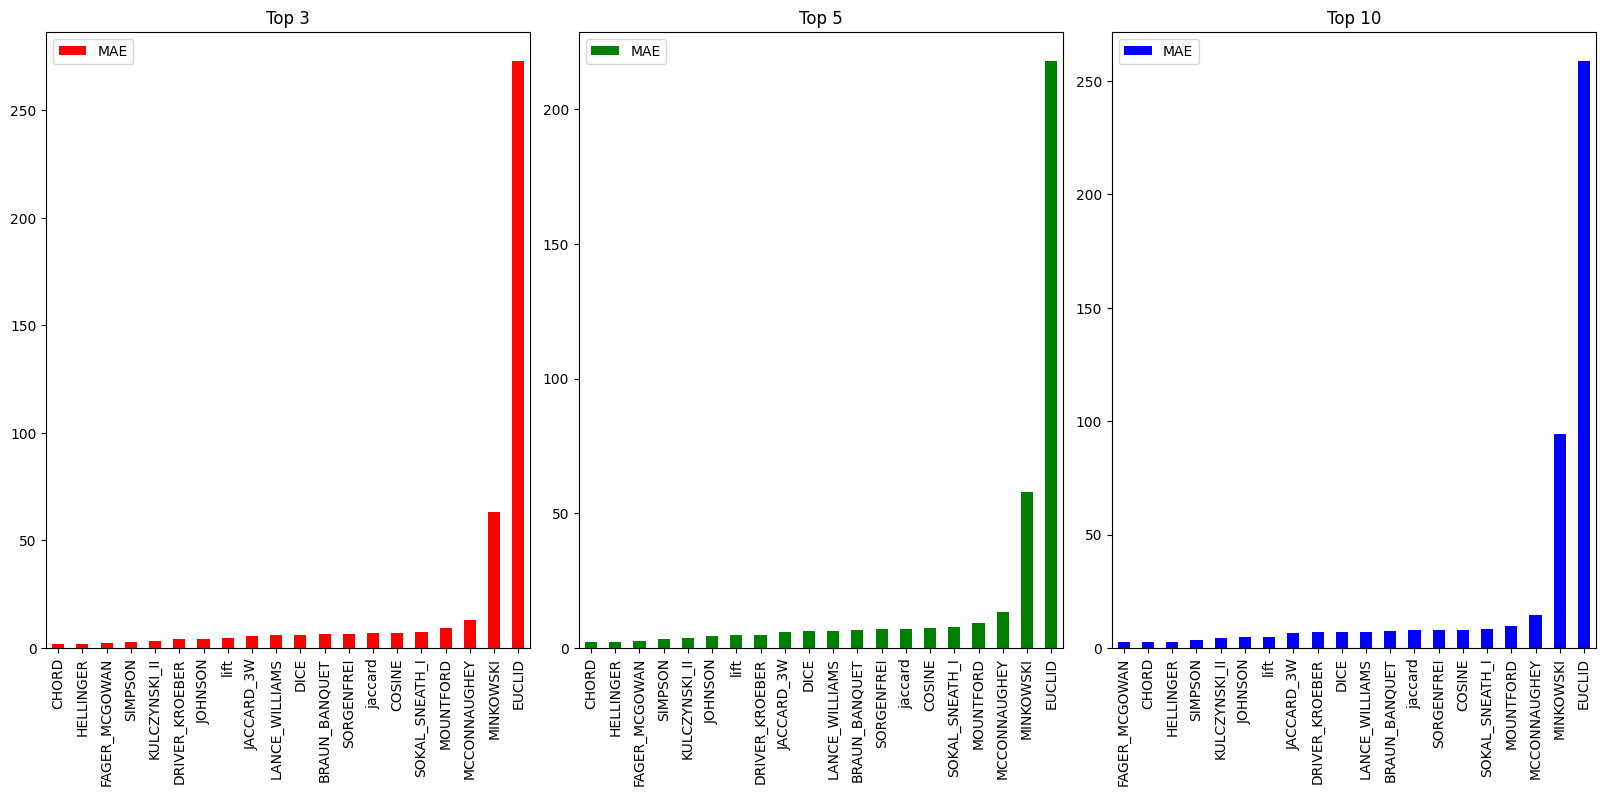

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][:split][['MAE']].sort_values(by='MAE',ascending=True)
    data['MAE'].plot(ax=axes[i], kind='bar', color=col[i], legend='MAE', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_MAE.jpg", bbox_inches='tight', dpi=1000)

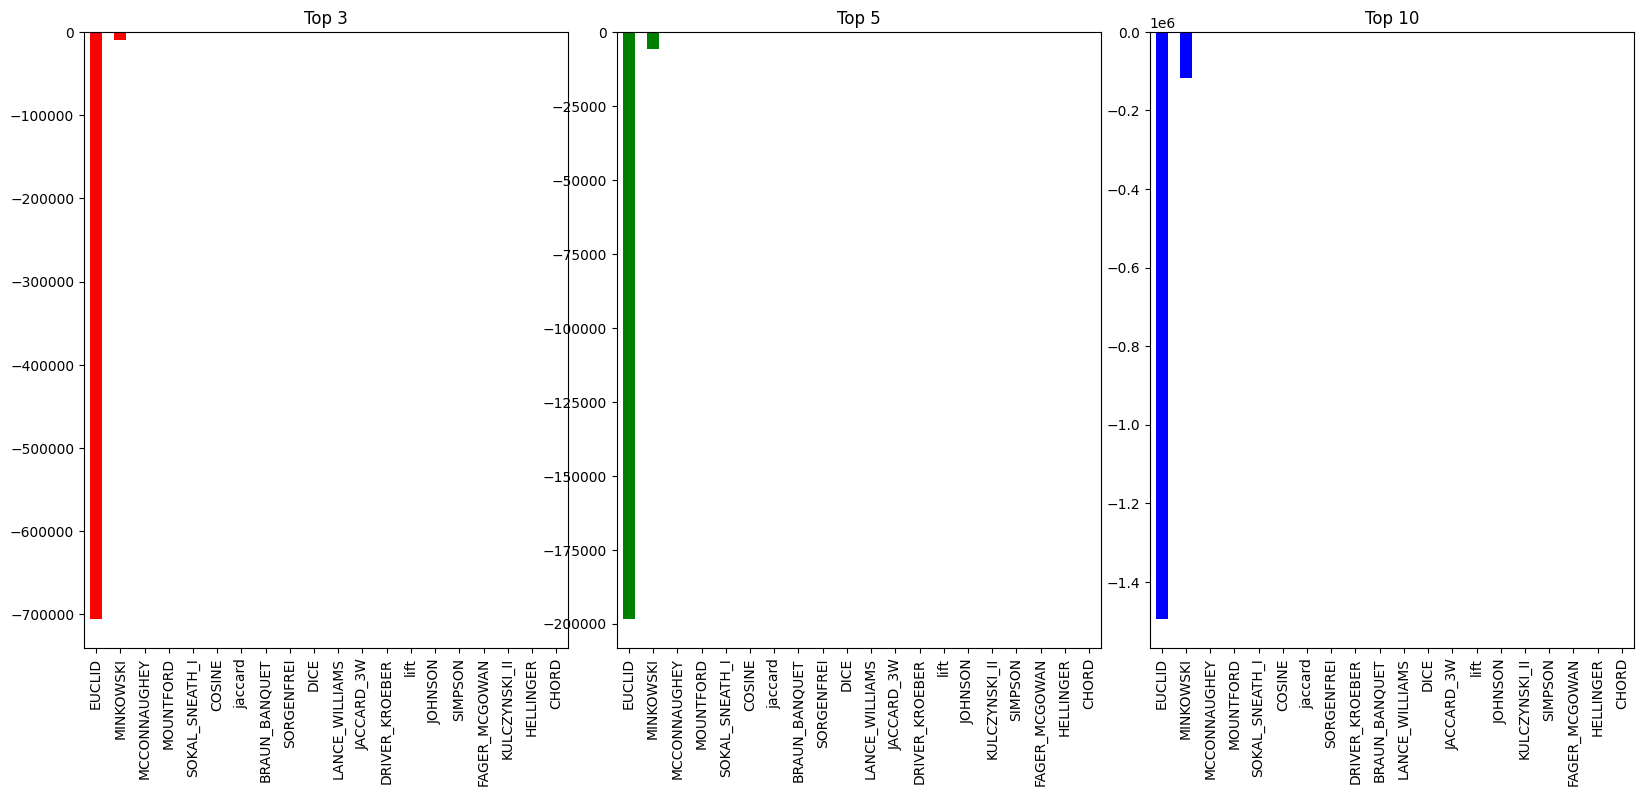

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][:split][['R2']].sort_values(by='R2',ascending=True)
    data['R2'].plot(ax=axes[i], kind='bar', color=col[i], y='R2', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_R2.jpg", bbox_inches='tight', dpi=1000)

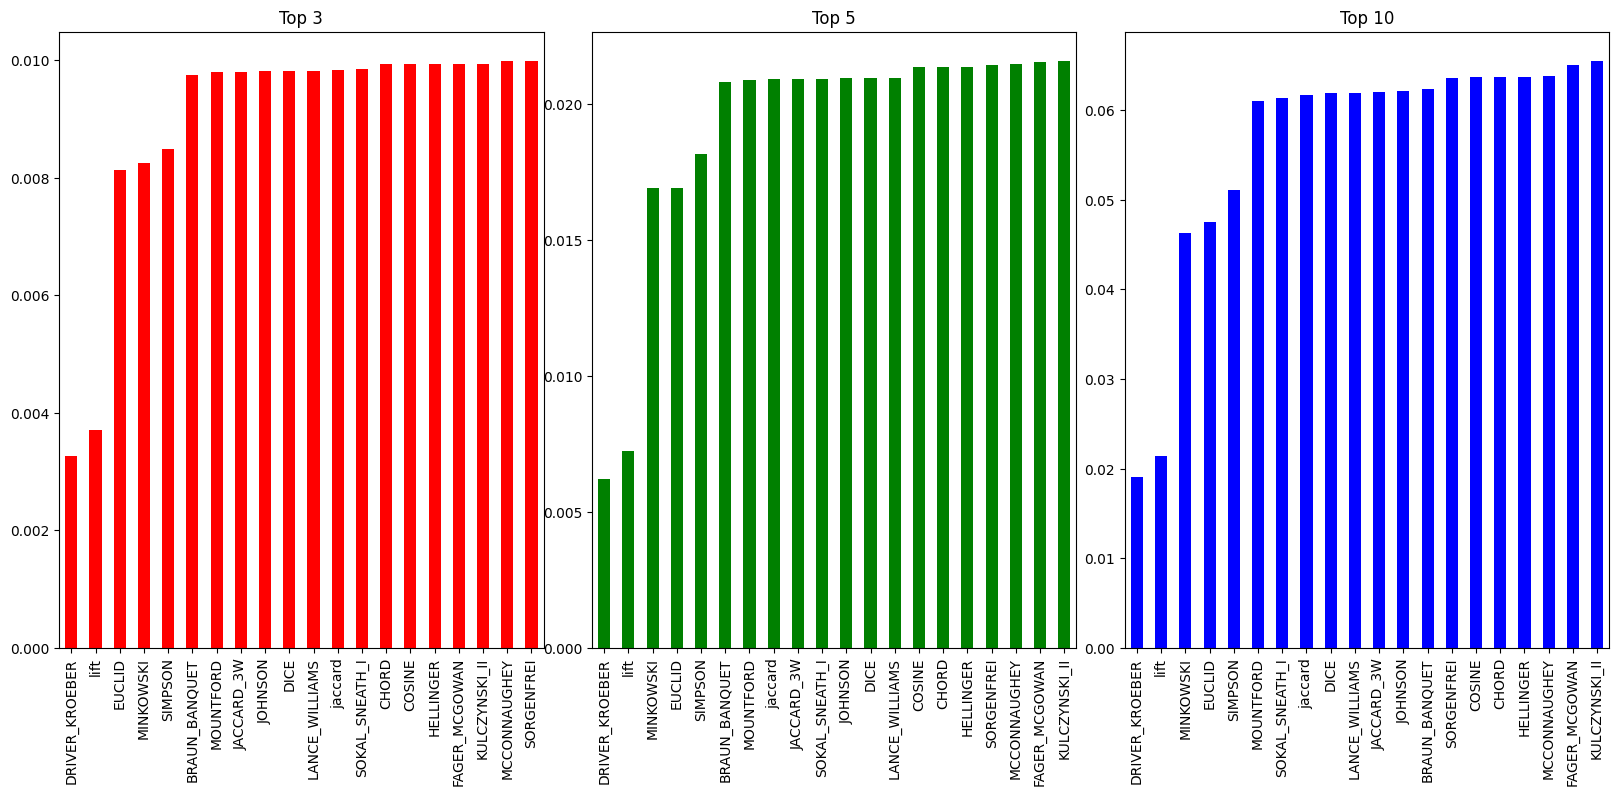

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][:split][['Precision@K']].sort_values(by='Precision@K',ascending=True)
    data['Precision@K'].plot(ax=axes[i], kind='bar', color=col[i], y='Precision@K', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_P@K.jpg", bbox_inches='tight', dpi=1000)

# Plot the MAE, P@K, and R² for the similarity metrics with negative co-occurrences

In [33]:
 #list_dataframe[0][split:].index

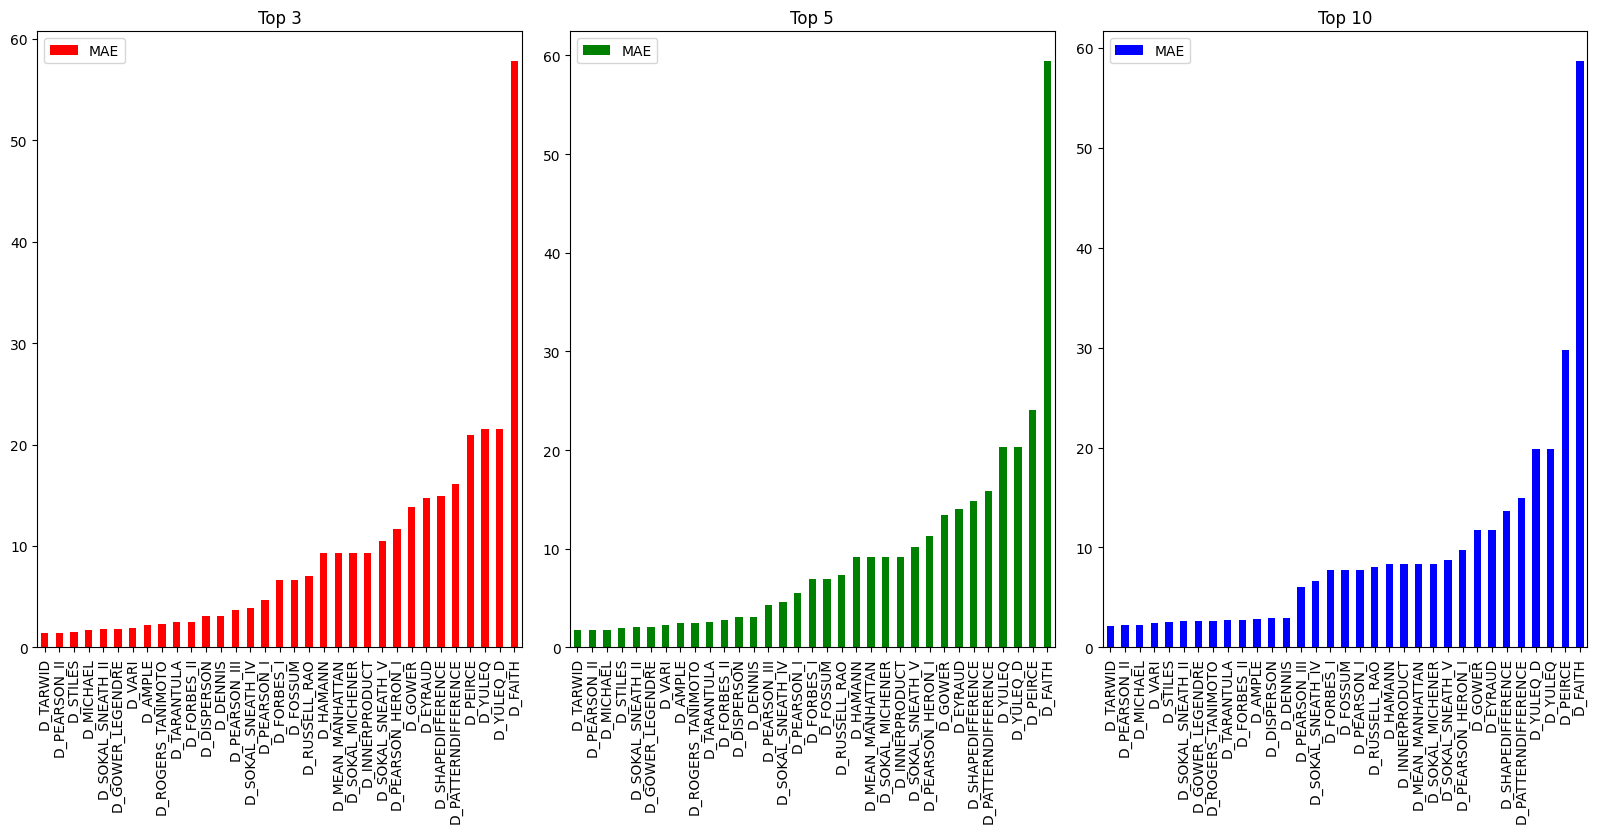

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][split:][['MAE']].sort_values(by='MAE',ascending=True)
    data['MAE'].plot(ax=axes[i], kind='bar', color=col[i], legend='MAE', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_D_MAE.jpg", bbox_inches='tight', dpi=1000)

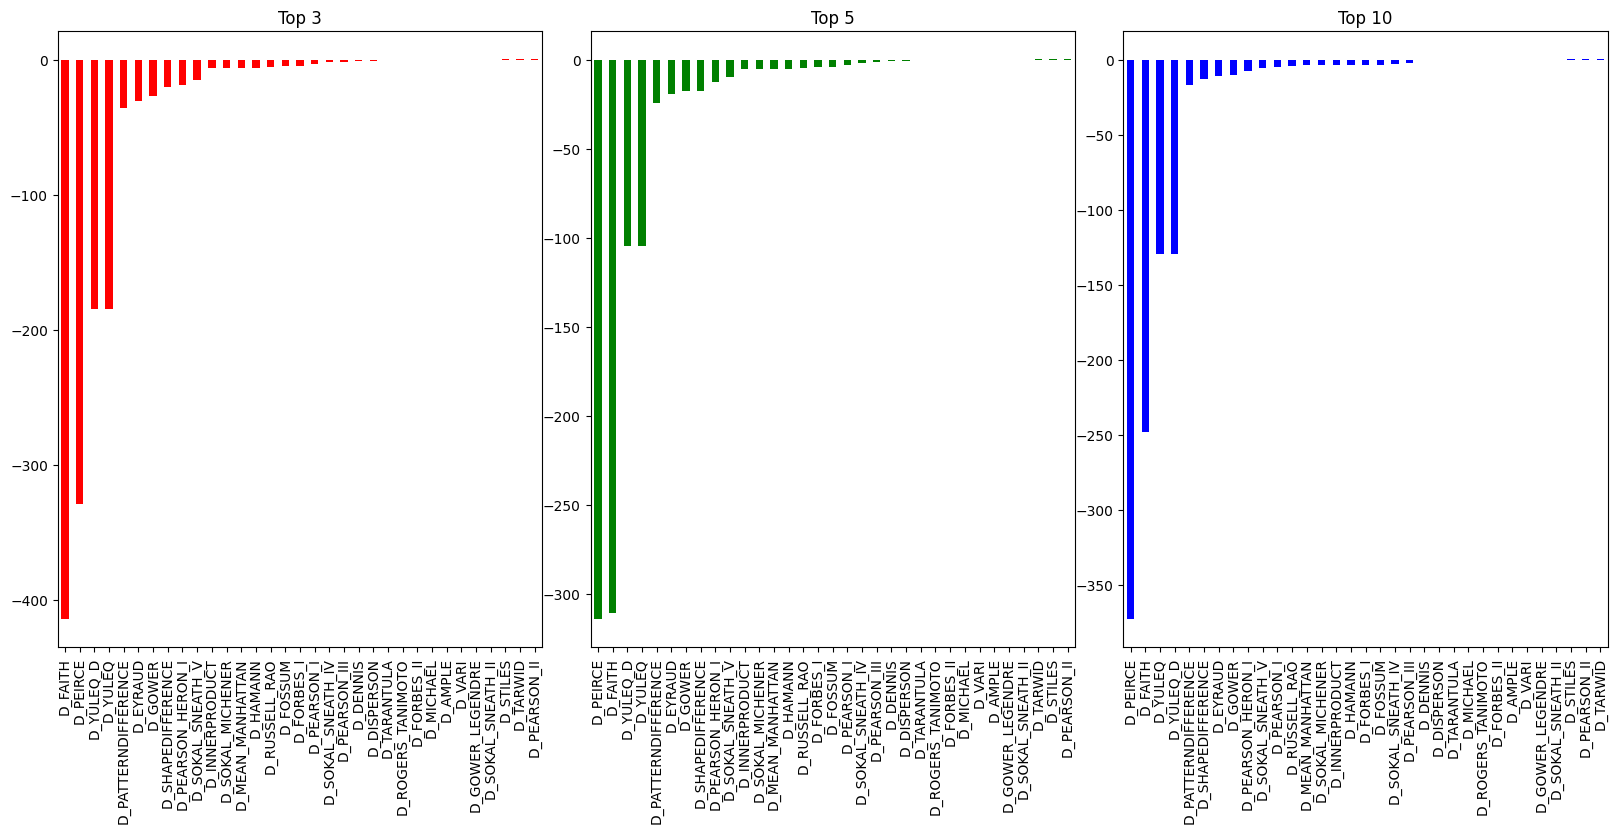

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][split:][['R2']].sort_values(by='R2',ascending=True)
    data['R2'].plot(ax=axes[i], kind='bar', color=col[i], y='R2', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_D_R2.jpg", bbox_inches='tight', dpi=1000)

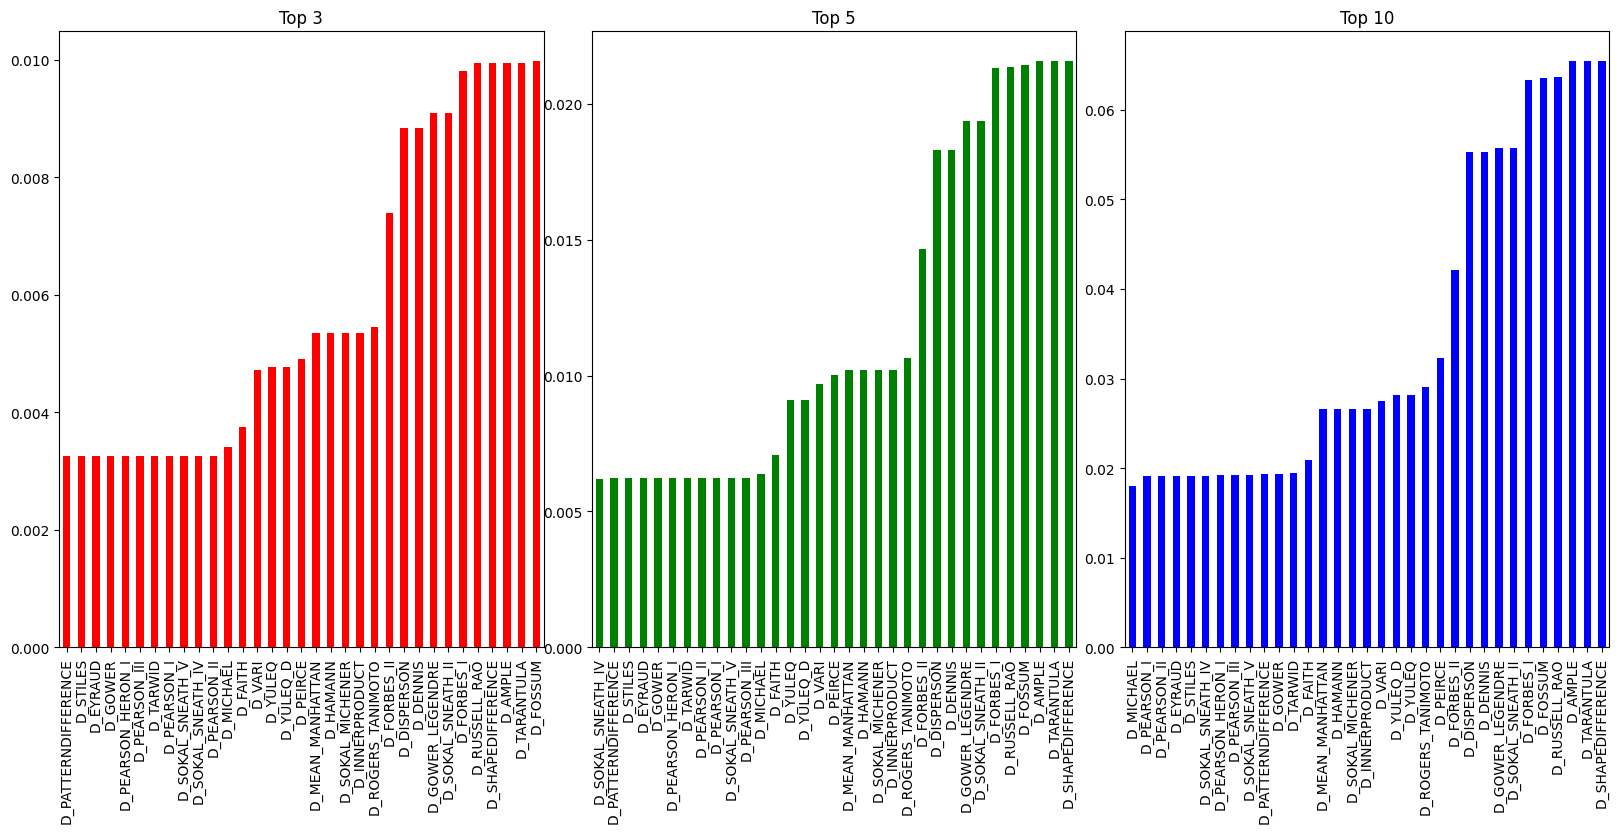

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3 , figsize=(20,8))
col=['r','g','b']
for i in range(len(list_top_k)):
    data=list_dataframe[i][split:][['Precision@K']].sort_values(by='Precision@K',ascending=True)
    data['Precision@K'].plot(ax=axes[i], kind='bar', color=col[i], y='Precision@K', x='Similarity', )
    axes[i].set_title(f'Top {list_top_k[i]}')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig("1M_D_P@K.jpg", bbox_inches='tight', dpi=1000)

# Plot the clustering of the similarity metrics with CAH 

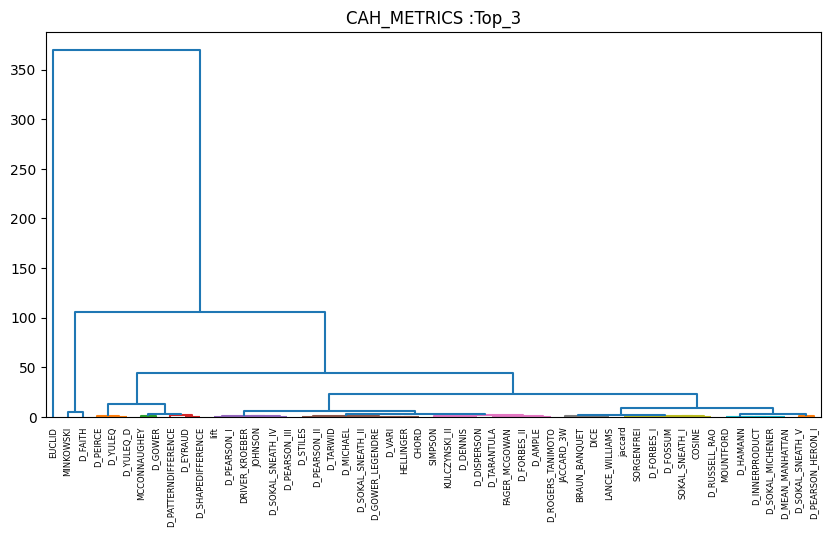

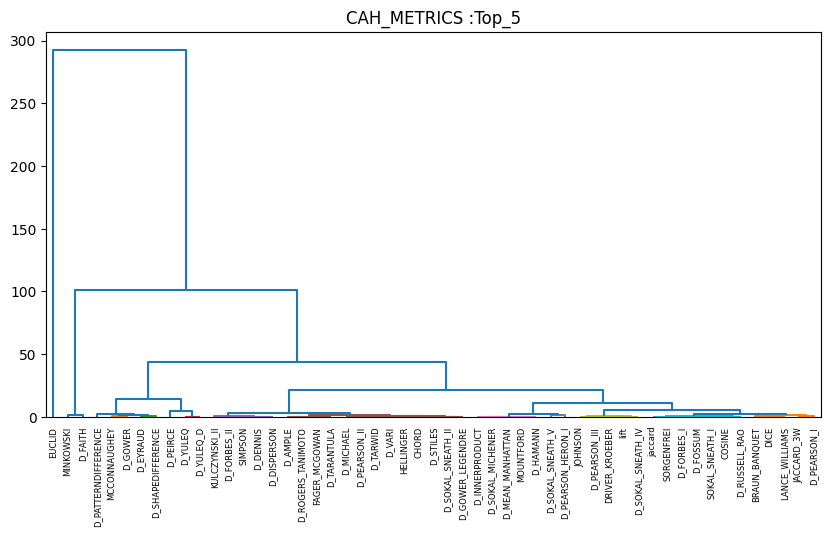

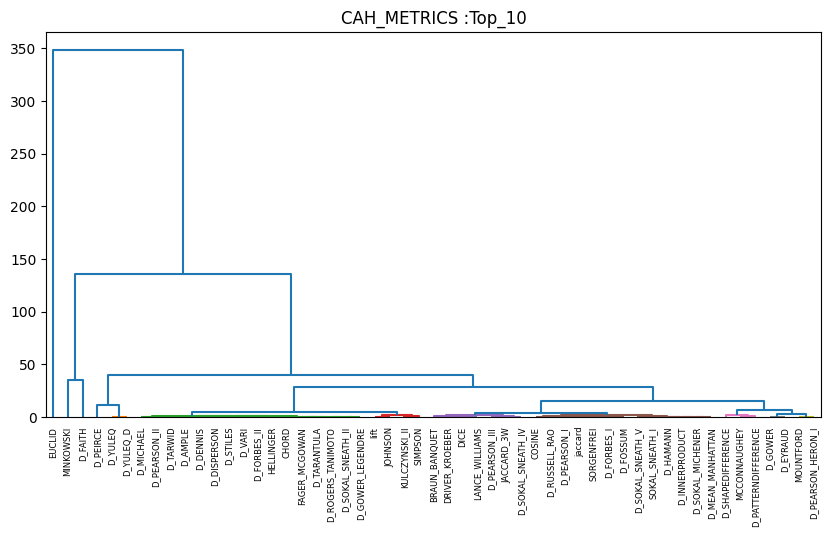

In [37]:
for i in range(len(list_top_k)):
    fig = plt.figure(figsize=(10,5))
    Z = linkage(list_dataframe[i].drop('R2',axis=1),method='ward',metric='euclidean') 
    # complete average ward single
    plt.title(f"CAH_METRICS :Top_{list_top_k[i]}")
    dendrogram(Z,labels=list_dataframe[i].index,orientation='top',color_threshold=1.5)
    plt.savefig(f'Top_{list_top_k[i]} clustring.png',dpi=1000)

In [38]:
# Save the cluster into local
#classter.to_excel("classterS.xlsx")

# Plot the correlation between the similarity metrics 

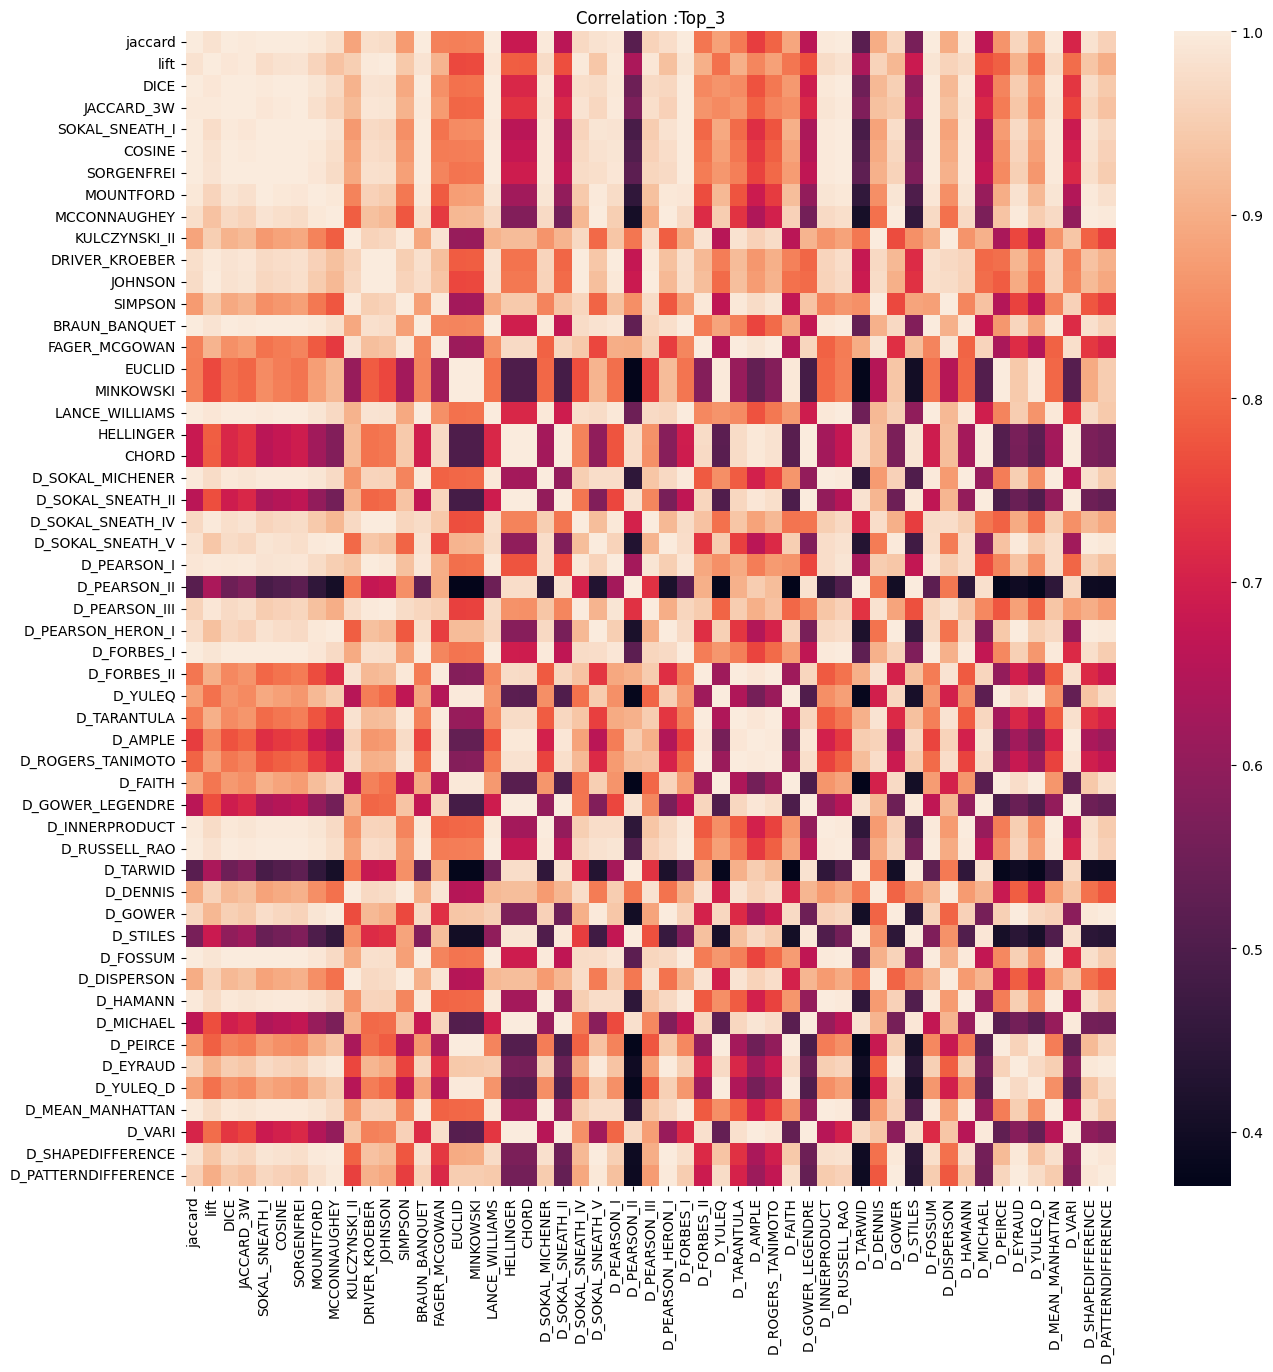

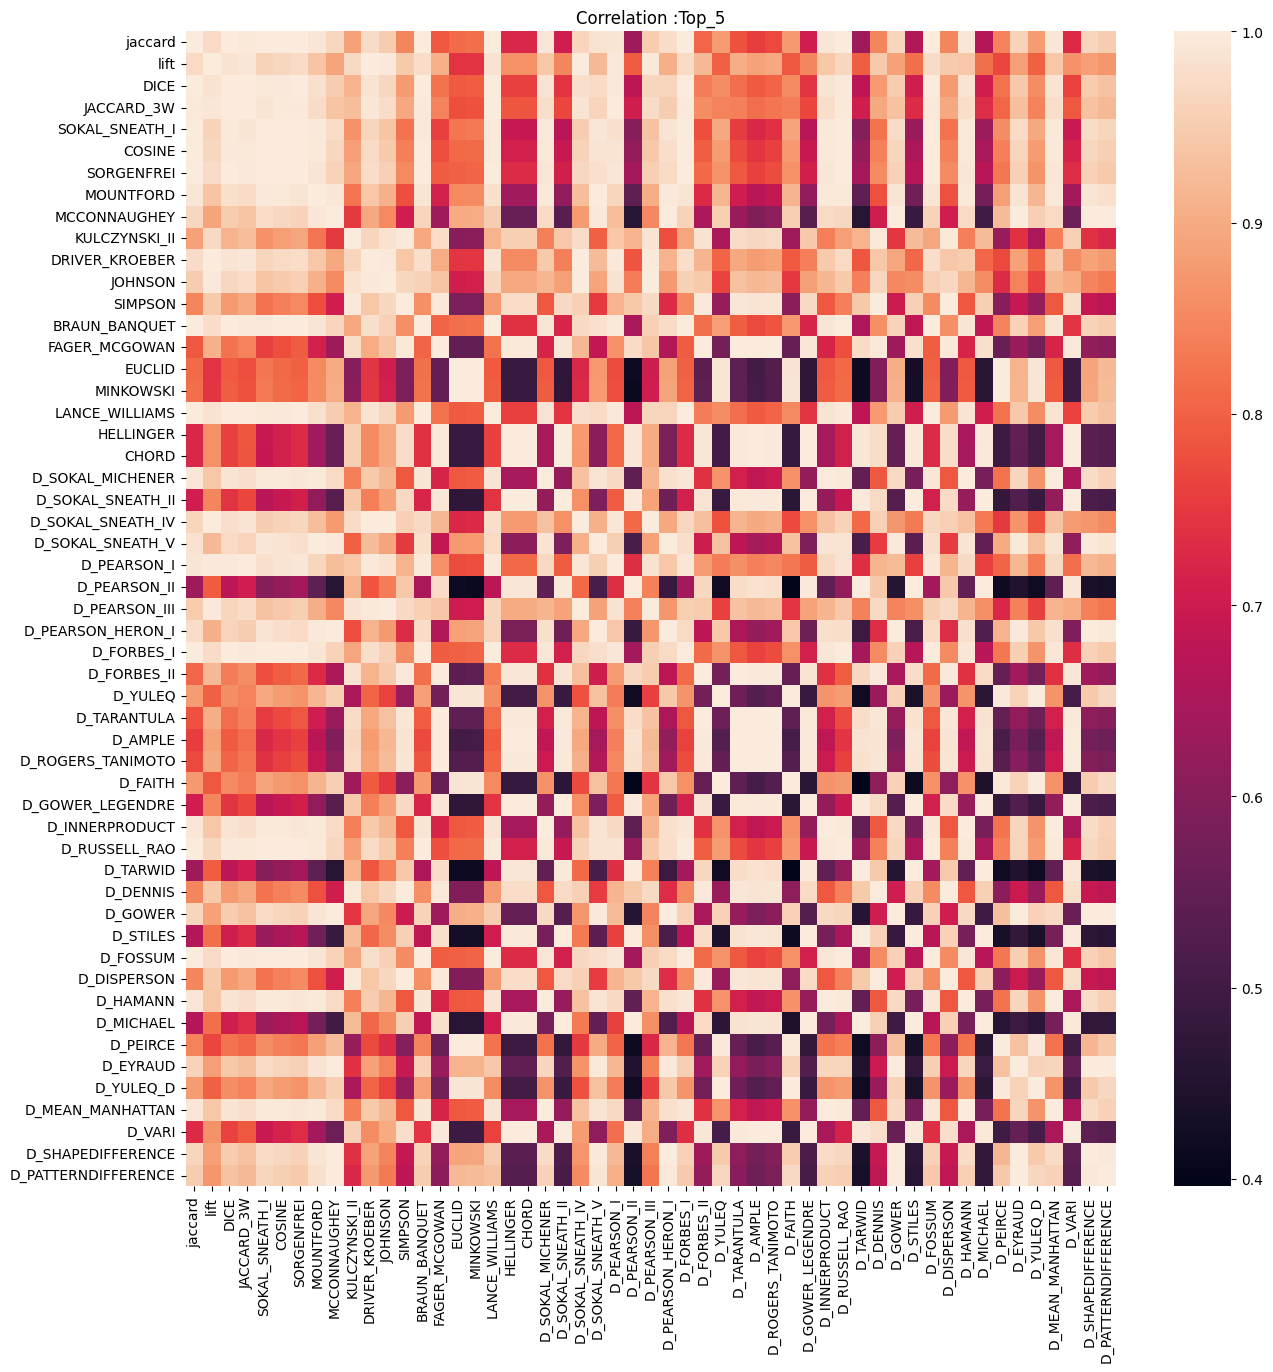

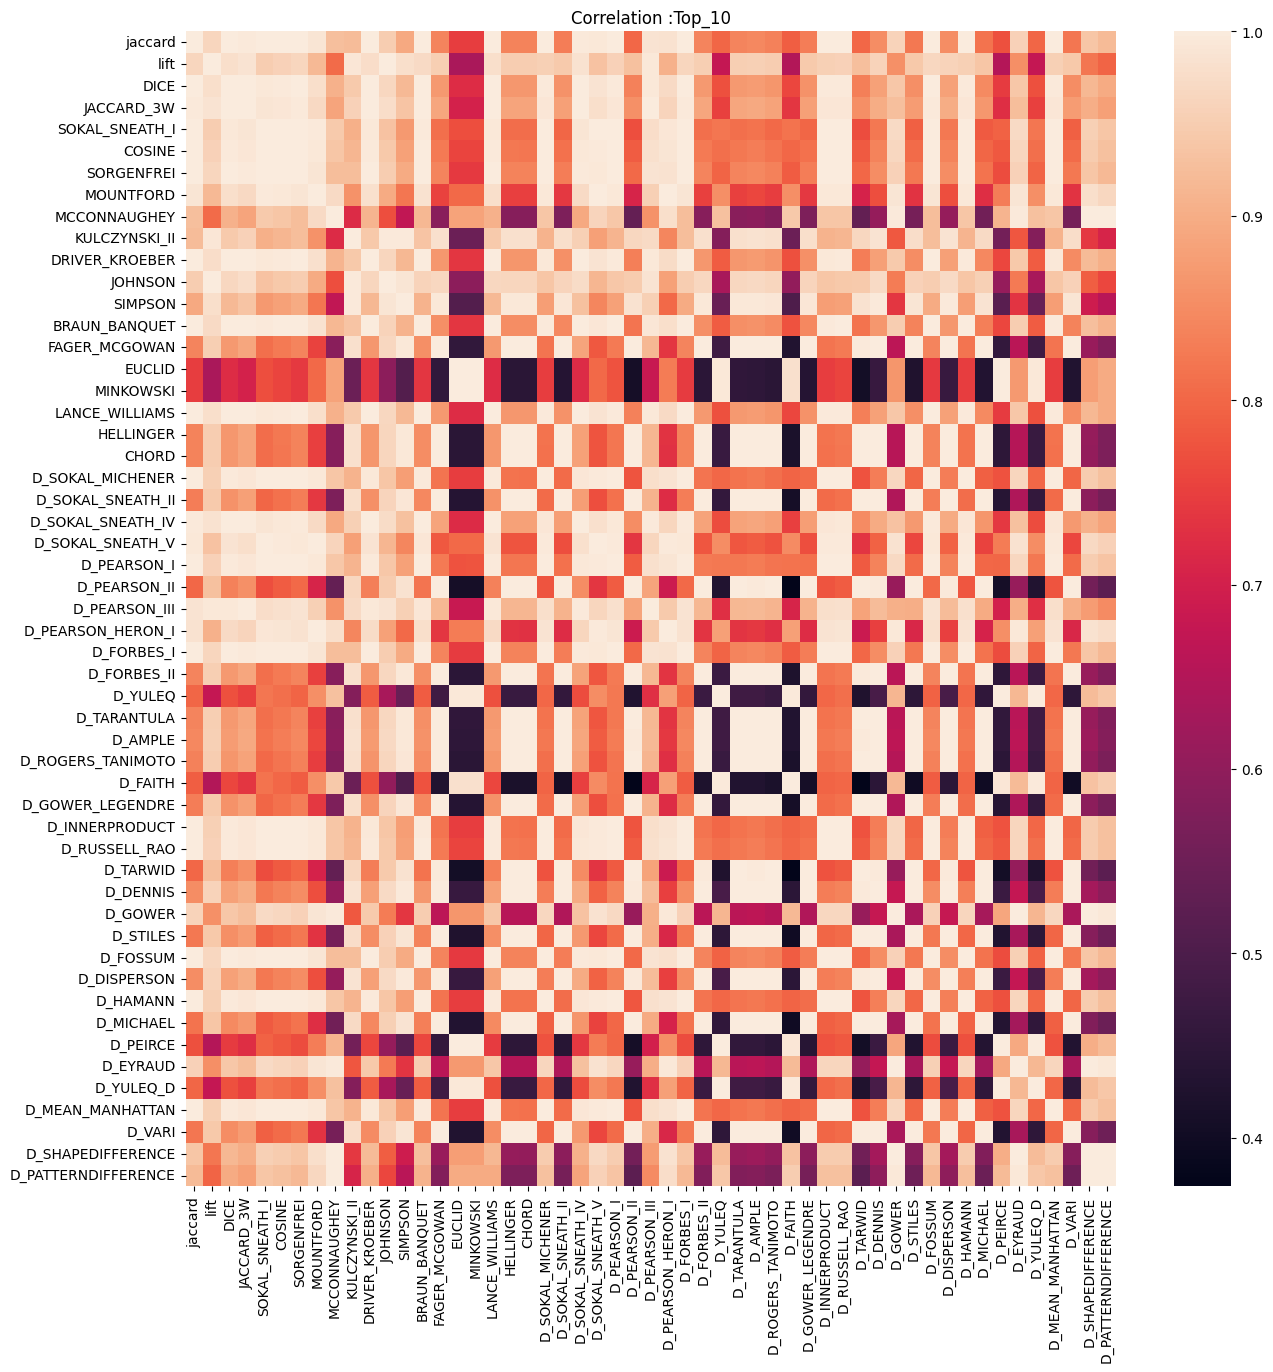

In [39]:
for i in range(len(list_top_k)):
    plt.figure(figsize=(15,15))
    sns.heatmap(data=list_dataframe[i].T.corr())
    plt.title(f"Correlation :Top_{list_top_k[i]}")
    plt.savefig(f'correlation ML_1M Top_{list_top_k[i]}.png',dpi=1000)

	The end